# Home Credit Default Risk 

## About Dataset

- application_{train|test}.csv

    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    - Static data for all applications. One row represents one loan in our data sample.

- bureau.csv

    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

- bureau_balance.csv

    - Monthly balances of previous credits in Credit Bureau.
    - This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

- pos_cash_balance.csv

    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

- credit_card_balance.csv

    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    - This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

- previous_application.csv

    - All previous applications for Home Credit loans of clients who have loans in our sample.
    - There is one row for each previous application related to loans in our data sample.

- installments_payments.csv

    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    - There is a) one row for every payment that was made plus b) one row each for missed payment.
        - One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

- home_credit_columns_description.csv

    - This file contains descriptions for the columns in the various data files.

![entity_relationship_diagram.png](../data/pictures/entity_relationship_diagram.png)

## Preliminaries

### Imports

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

%cd ..

from models.risk_model import RiskModel
from utils.exploratory_data_analysis_functions import (
    create_comprehensive_bivariate_analysis,
    print_feature_importance_summary,
    analyze_mutual_information,
)

%cd notebooks/

/Users/vytautas.cepas/Documents/turing_college/TuringCollegeSubmissions/vcepas-DS.v2.5.3.4.1
/Users/vytautas.cepas/Documents/turing_college/TuringCollegeSubmissions/vcepas-DS.v2.5.3.4.1/notebooks
/Users/vytautas.cepas/Documents/turing_college/TuringCollegeSubmissions/vcepas-DS.v2.5.3.4.1/notebooks


### Configurations

In [2]:
sns.set_theme(style="whitegrid")

### Initialization of Constant Variables

In [3]:
DATA_DIRECTORY = Path("../data")
RANDOM_STATE = 0

## Risk Score Prediction Model Development

This section develops a Risk Score Prediction Model that can be used with client questionnaire data to predict default risk.

### Importing Dataset into Dataframe

In [4]:
application_df = pd.read_parquet(path=DATA_DIRECTORY / "application_train.parquet")
application_df.columns = application_df.columns.str.lower()

In [5]:
print("Missing values per column:")
application_df.isnull().sum().sort_values(ascending=False)

Missing values per column:


commonarea_medi             214865
commonarea_avg              214865
commonarea_mode             214865
nonlivingapartments_mode    213514
nonlivingapartments_avg     213514
                             ...  
name_housing_type                0
name_family_status               0
name_education_type              0
name_income_type                 0
sk_id_curr                       0
Length: 122, dtype: int64

In [6]:
print(f"Dataset shape: {application_df.shape}")
print(f"Default rate: {application_df['target'].mean():.3f}")

Dataset shape: (307511, 122)
Default rate: 0.081


### Wrangling, Feature Selection and Analysis

Let's identify the most important features that can be easily collected from clients through a questionnaire AND exist in dataset.

In [7]:
questionnaire_features = [
    "code_gender",  # Gender of the client
    "flag_own_car",  # Whether client owns a car
    "flag_own_realty",  # Whether client owns house/flat
    "cnt_children",  # Number of children
    "amt_income_total",  # Total income
    "name_income_type",  # Type of income (working, pensioner, etc.)
    "name_education_type",  # Education level
    "name_family_status",  # Family status (married, single, etc.)
    "name_housing_type",  # Housing situation
    "days_birth",  # Age (will convert to years)
    "days_employed",  # Employment duration (will convert to years)
    "cnt_fam_members",  # Number of family members
    "name_contract_type",  # Type of loan contract
    "amt_credit",  # Credit amount requested
    "amt_annuity",  # Loan annuity amount
]

#### Creating more understandable features

In [8]:
model_df = (
    application_df[questionnaire_features + ["target"]]
    .assign(
        age_years=lambda df: -df["days_birth"] / 365,
        years_employed=lambda df: np.where(
            -df["days_employed"] / 365 < 0,
            0,  # we presume that negative values indicate that client has not worked at all
            -df["days_employed"] / 365,
        ),
    )
    .drop(columns=["days_birth", "days_employed"])
    .rename(
        columns={
            "code_gender": "gender",
            "flag_own_car": "owns_car",
            "flag_own_realty": "owns_housing",
            "cnt_children": "num_children",
            "amt_income_total": "total_income",
            "name_income_type": "income_type",
            "name_education_type": "education_level",
            "name_family_status": "family_status",
            "name_housing_type": "housing_type",
            "cnt_fam_members": "num_family_members",
            "name_contract_type": "contract_type",
            "amt_credit": "credit_amount",
            "amt_annuity": "loan_annuity",
            "target": "defaulted",
        }
    )
)

#### Impute missing values for amt_annuity and cnt_fam_members in model_df

In [9]:
model_df.isnull().sum()[model_df.isnull().sum() > 0].sort_values(ascending=False)

loan_annuity          12
num_family_members     2
dtype: int64

Due to very low number of missing values we will simply impute missing values with median.

In [10]:
model_df["loan_annuity"] = model_df["loan_annuity"].fillna(
    model_df["loan_annuity"].median()
)
model_df["num_family_members"] = model_df["num_family_members"].fillna(
    model_df["num_family_members"].median()
)

#### Bivariate Analysis

BIVARIATE ANALYSIS
NUMERICAL FEATURES - LINE DENSITY PLOTS
--------------------------------------------------
NUM_CHILDREN:
  No Default: mean=0.4, std=0.7
  Default:    mean=0.5, std=0.8
  Cohen's d:  0.070 (Small) ***

TOTAL_INCOME:
  No Default: mean=169077.7, std=110476.3
  Default:    mean=165611.8, std=746677.0
  Cohen's d:  -0.015 (Small) *

NUM_CHILDREN:
  No Default: mean=0.4, std=0.7
  Default:    mean=0.5, std=0.8
  Cohen's d:  0.070 (Small) ***

TOTAL_INCOME:
  No Default: mean=169077.7, std=110476.3
  Default:    mean=165611.8, std=746677.0
  Cohen's d:  -0.015 (Small) *

NUM_FAMILY_MEMBERS:
  No Default: mean=2.2, std=0.9
  Default:    mean=2.2, std=1.0
  Cohen's d:  0.034 (Small) ***

CREDIT_AMOUNT:
  No Default: mean=602648.3, std=406845.9
  Default:    mean=557778.5, std=346433.2
  Cohen's d:  -0.112 (Small) ***

NUM_FAMILY_MEMBERS:
  No Default: mean=2.2, std=0.9
  Default:    mean=2.2, std=1.0
  Cohen's d:  0.034 (Small) ***

CREDIT_AMOUNT:
  No Default: mean=602648.

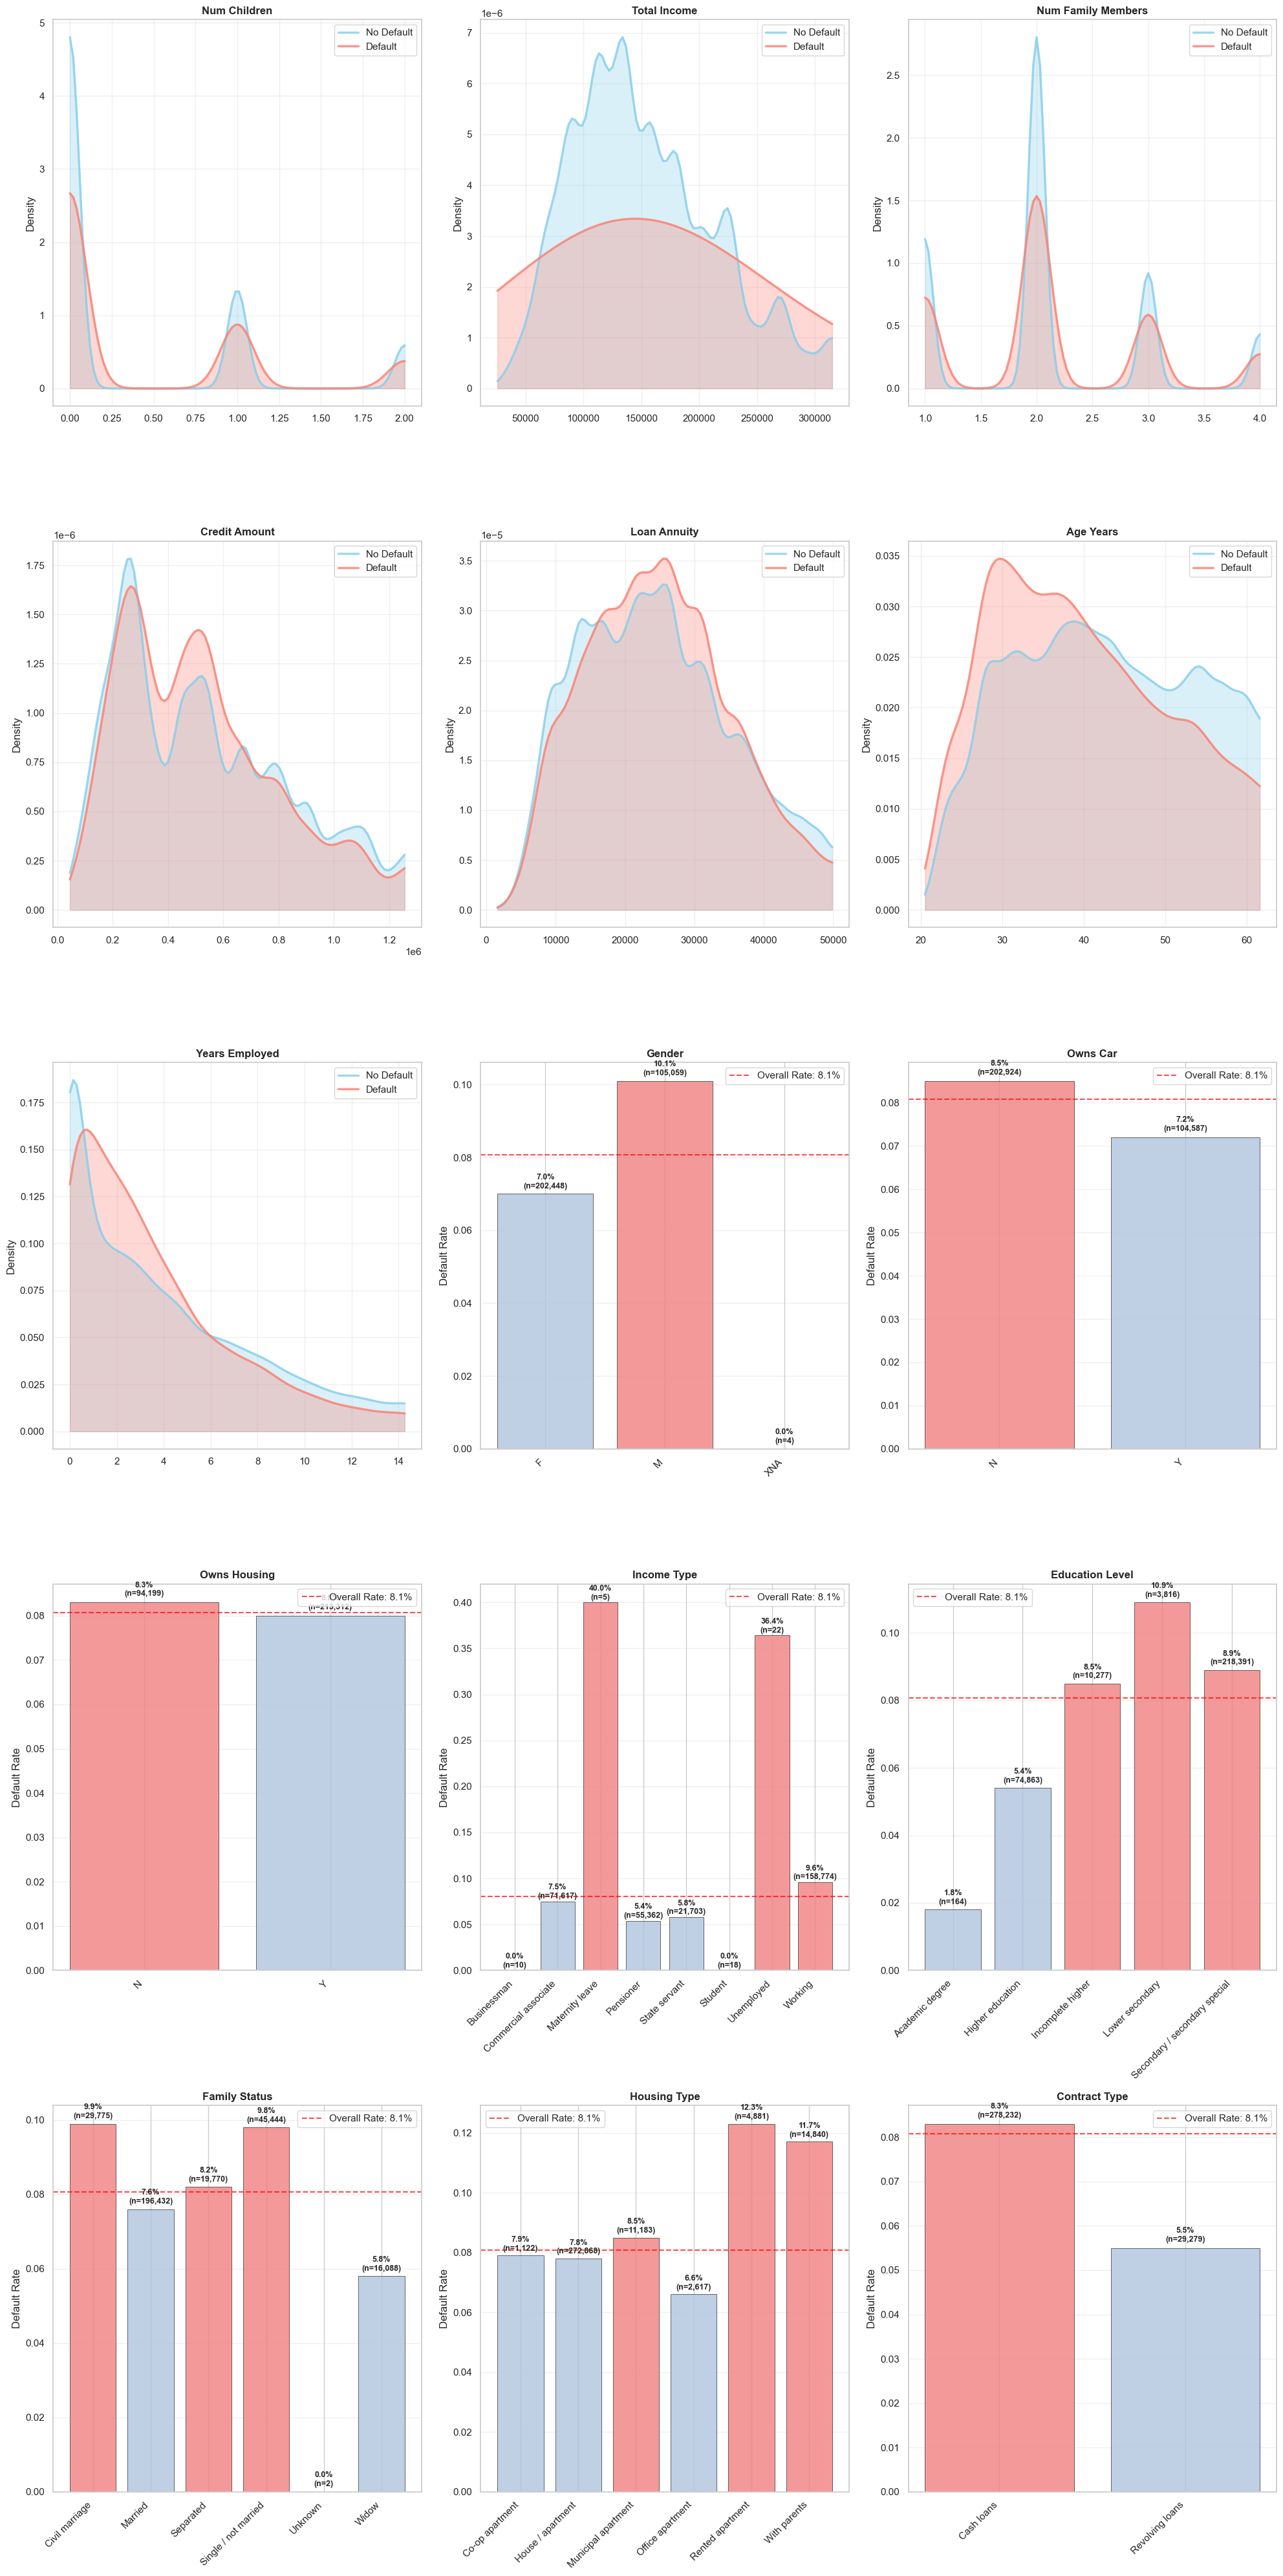

In [11]:
analysis_results = create_comprehensive_bivariate_analysis(
    data=model_df,
    numerical_features=model_df.drop(columns="defaulted", errors="ignore")
    .select_dtypes(exclude=["object"])
    .columns,
    categorical_features=model_df.drop(columns="defaulted", errors="ignore")
    .select_dtypes(include=["object"])
    .columns,
    target_col="defaulted",
)

### Correlation Analysis

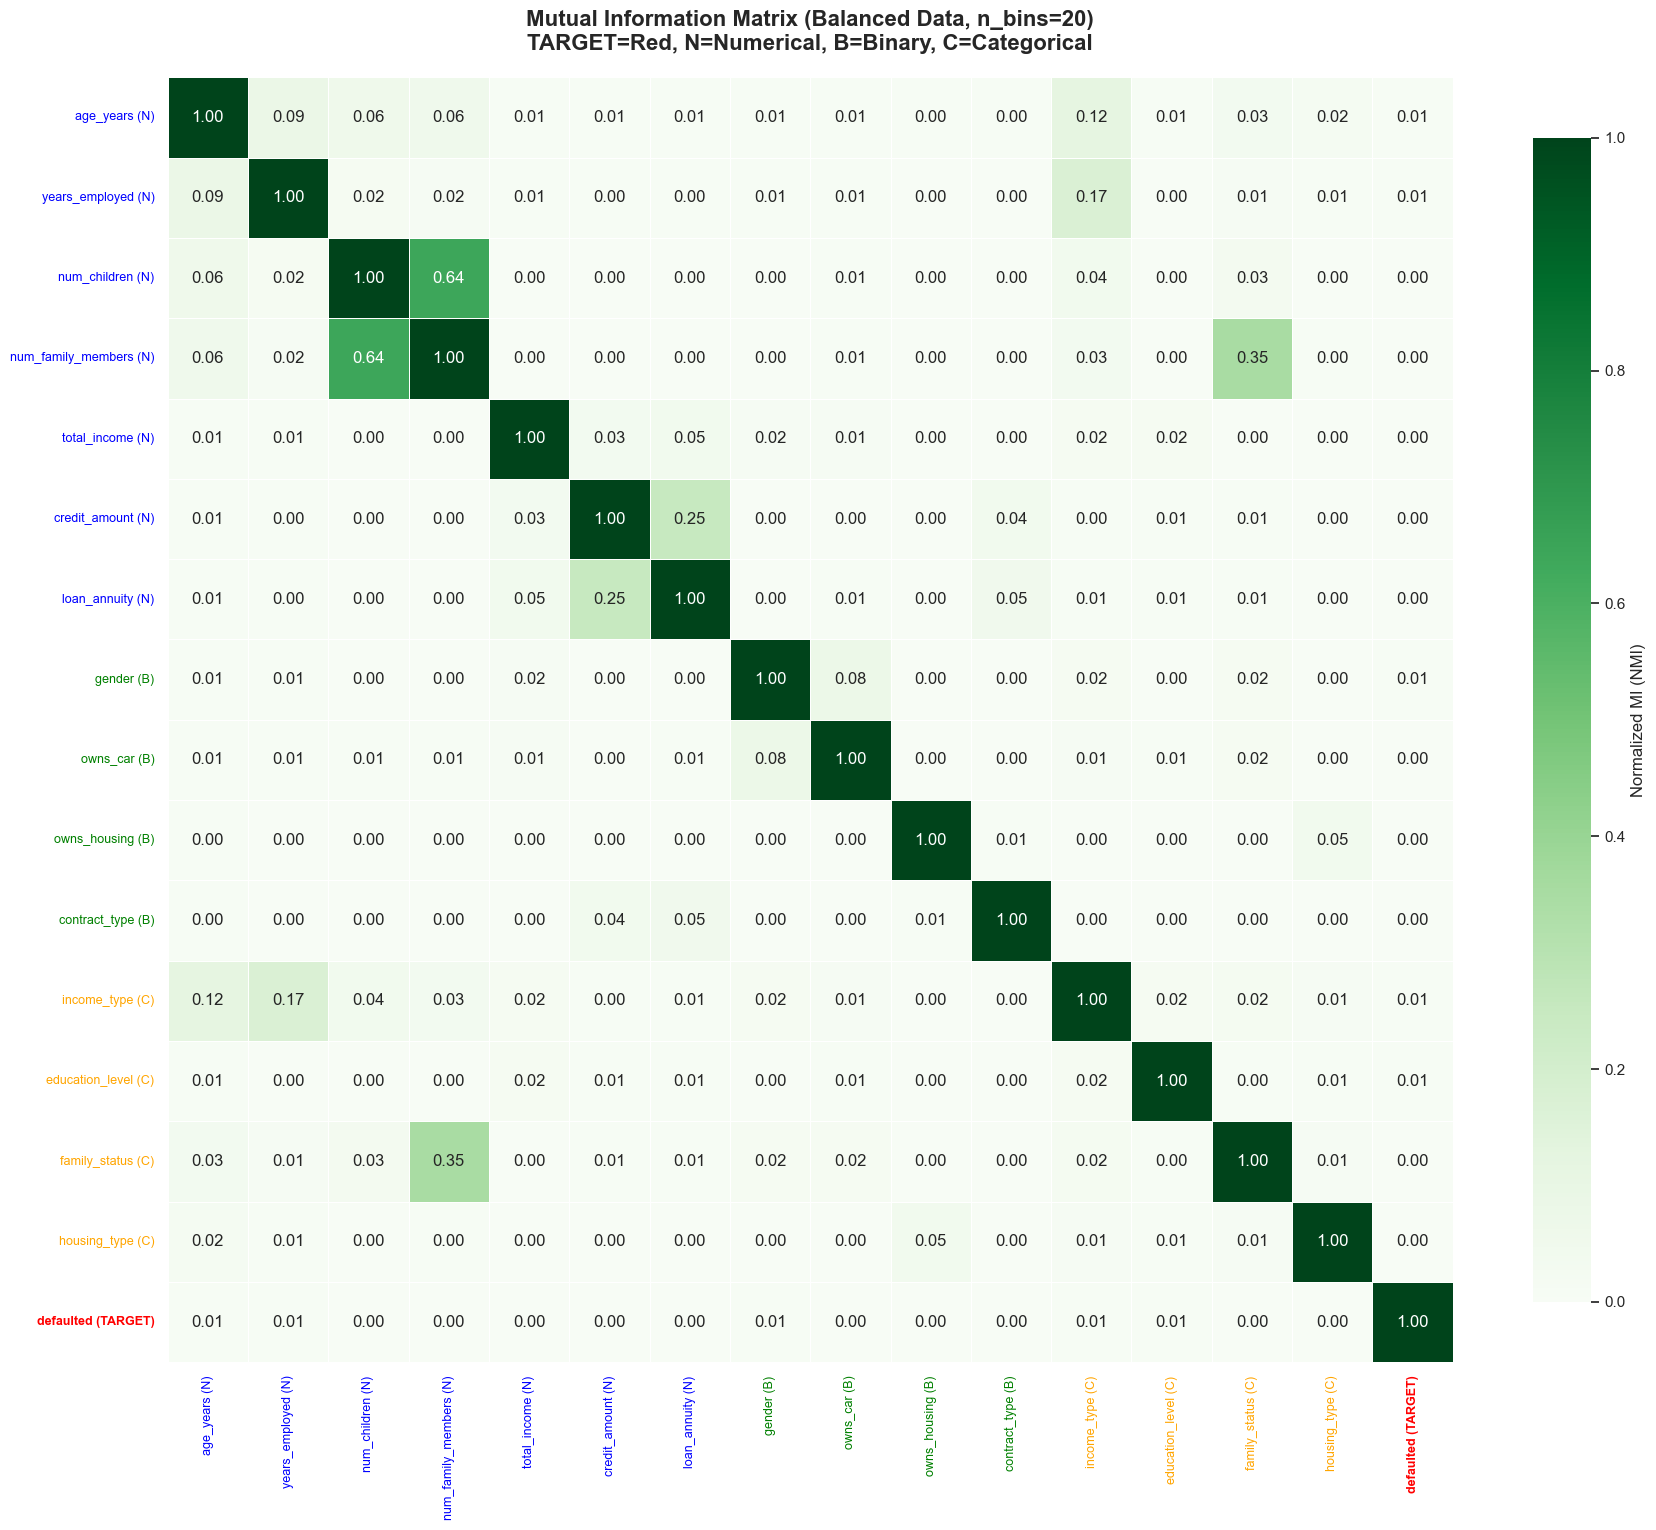

SUMMARY STATISTICS

Top 10 features by MI with defaulted:
Feature                   Type   NMI       


In [ ]:
feature_groups = {
    "numerical": [
        "age_years",
        "years_employed",
        "num_children",
        "num_family_members",
        "total_income",
        "credit_amount",
        "loan_annuity",
    ],
    "binary": ["gender", "owns_car", "owns_housing", "contract_type"],
    "categorical": ["income_type", "education_level", "family_status", "housing_type"],
}

binary_encoding = {
    "gender": ("M", 1),
    "owns_car": ("Y", 1),
    "owns_housing": ("Y", 1),
    "contract_type": ("Cash loans", 1),
}

mi_df, discretized_df = analyze_mutual_information(
    df=model_df,
    target_col="defaulted",
    feature_groups=feature_groups,
    binary_encoding=binary_encoding,
    n_bins=20,
    balance_data=True,
    figsize=(18, 16),
    random_state=0,
)

In [13]:
print_feature_importance_summary(analysis_results)

FEATURE IMPORTANCE SUMMARY
NUMERICAL FEATURES - RANKED BY EFFECT SIZE:
--------------------------------------------------
 1. age_years           : Cohen's d = -0.288 (Medium) ***
 2. years_employed      : Cohen's d = -0.169 (Small ) ***
 3. credit_amount       : Cohen's d = -0.112 (Small ) ***
 4. num_children        : Cohen's d =  0.070 (Small ) ***
 5. loan_annuity        : Cohen's d = -0.047 (Small ) ***
 6. num_family_members  : Cohen's d =  0.034 (Small ) ***
 7. total_income        : Cohen's d = -0.015 (Small ) *

CATEGORICAL FEATURES - RANKED BY DEFAULT RATE RANGE:
--------------------------------------------------
 1. income_type         : 0.0% - 40.0% (range: 40.0%)
 2. gender              : 0.0% - 10.1% (range: 10.1%)
 3. family_status       : 0.0% - 9.9% (range: 9.9%)
 4. education_level     : 1.8% - 10.9% (range: 9.1%)
 5. housing_type        : 6.6% - 12.3% (range: 5.7%)
 6. contract_type       : 5.5% - 8.3% (range: 2.8%)
 7. owns_car            : 7.2% - 8.5% (range: 1.3%)

In [14]:
risk_model = RiskModel(data_directory=DATA_DIRECTORY, random_state=RANDOM_STATE)
print("Loading pre-trained model from assets...")
model_path = Path("../streamlit_app/src/assets/risk_prediction_model.pkl")
risk_model.load(str(model_path.absolute()))

print("\nModel loaded successfully!")
print(f"Total features: {len(risk_model.feature_names)}")
print(f"Model is trained: {risk_model.is_trained}")
print(f"SHAP explainer initialized: {risk_model.shap_explainer is not None}")

results = {
    "optimal_threshold": risk_model.optimal_threshold,
}

Loading pre-trained model from assets...
Model loaded from: /Users/vytautas.cepas/Documents/turing_college/TuringCollegeSubmissions/vcepas-DS.v2.5.3.4.1/notebooks/../streamlit_app/src/assets/risk_prediction_model.pkl

Model loaded successfully!
Total features: 41
Model is trained: True
SHAP explainer initialized: True


#### Feature Importance Analysis

Now let's create a comprehensive feature importance chart that matches what users see in the Streamlit application.

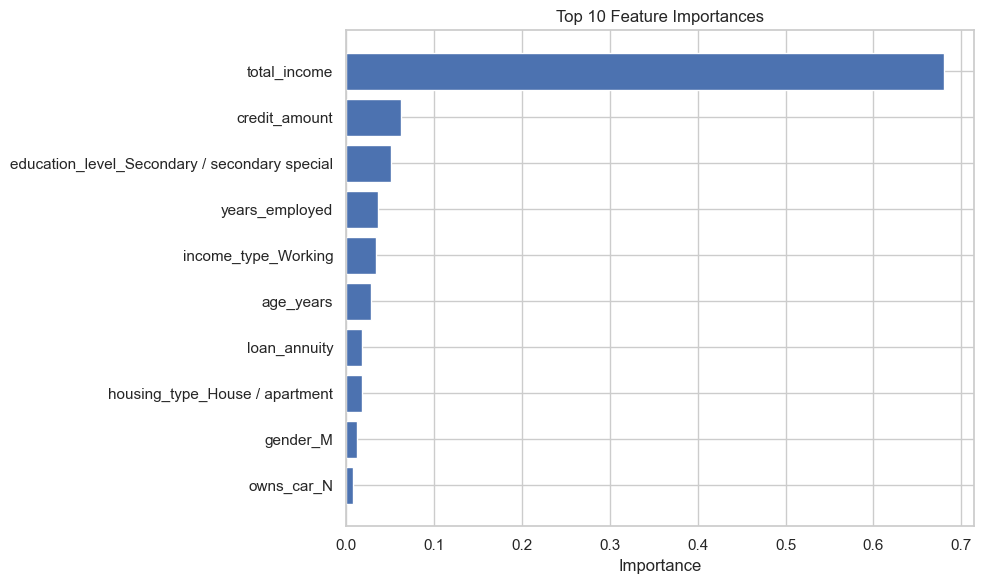

In [15]:
feature_importance = risk_model.plot_feature_importance(top_n=10)

#### Baseline Comparison

In [ ]:
X = model_df.drop("defaulted", axis=1)
y = model_df["defaulted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
y_pred_proba = risk_model.pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= risk_model.optimal_threshold).astype(int)
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)

print("Model Comparison:")
print(f"{'Metric':<20} {'Baseline':<12} {'Current Model':<15} {'Improvement'}")
print("-" * 60)

metrics = {
    "ROC-AUC": (0.5, roc_auc_score(y_test, y_pred_proba)),
    "Accuracy": (accuracy_score(y_test, baseline_pred), accuracy_score(y_test, y_pred)),
}

for metric, (base, current) in metrics.items():
    improvement = ((current - base) / base * 100) if base > 0 else 0
    print(f"{metric:<20} {base:<12.4f} {current:<15.4f} {improvement:.1f}%")

Model Comparison:
Metric               Baseline     Current Model   Improvement
------------------------------------------------------------
ROC-AUC              0.5000       0.6567          +31.3%
Accuracy             0.9193       0.6680          +-27.3%


#### Variance Explained

In [17]:
r2 = abs(r2_score(y_test, y_pred_proba))
print(f"Model Variance Explained (R²): {r2:.4f}")

Model Variance Explained (R²): 0.3785


#### Confusion Matrix

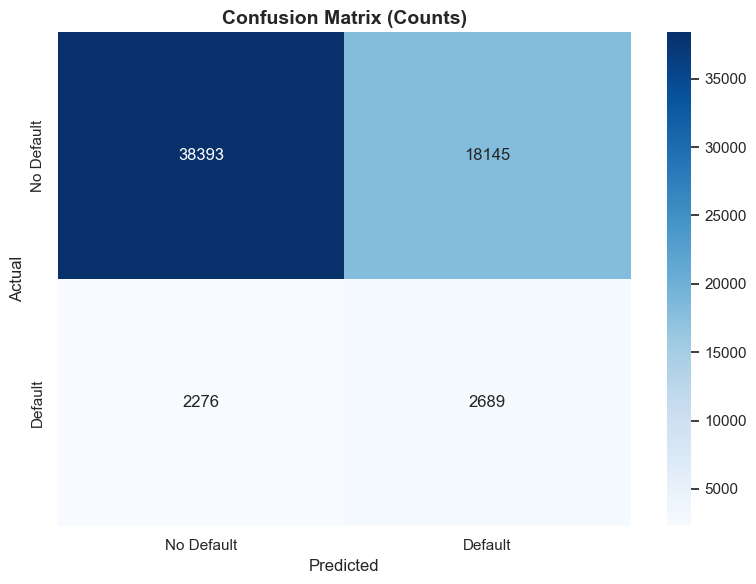

In [18]:
cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes,
    xticklabels=["No Default", "Default"],
    yticklabels=["No Default", "Default"],
)
axes.set_title("Confusion Matrix (Counts)", fontsize=14, weight="bold")
axes.set_ylabel("Actual")
axes.set_xlabel("Predicted")

plt.tight_layout()
plt.show()

The model’s accuracy is fairly decent. Given the features it was trained on, it was quite difficult to improve the accuracy further. To enhance performance, we would need more informative features. Additionally, we could develop other models — not necessarily machine learning ones — and ensemble them to increase predictive power.